# ML Session 8주차 : Ensemble, Voting, Stacking

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 유방암 데이터 불러오기
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
cancer.data.shape, cancer.feature_names

((569, 30),
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'], dtype='<U23'))

**[유방암 진단 데이터]**
- target : 유방암 진단 여부 (0, 1)
- feature : 30개 ('mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness' 등)

In [3]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

## 기본 모델

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [21]:
# 기본 모델 저장
clfs = []
LR=LogisticRegression(random_state=34); clfs.append(LR)
DT=DecisionTreeClassifier(random_state=34); clfs.append(DT)
MLP=MLPClassifier(random_state=34); clfs.append(MLP)
KNN=KNeighborsClassifier(); clfs.append(KNN)
RF=RandomForestClassifier(random_state=34); clfs.append(RF)
GBM=GradientBoostingClassifier(random_state=34); clfs.append(GBM)

In [22]:
# 각 모델별 prediction 저장 및 성능(Accuracy) 확인
pred_results = []
for clf in clfs :
    pred = clf.fit(X_train, y_train).predict(X_test)
    name = type(clf).__name__
    pred_results.append(pd.Series(pred, name=name))
    print("{:30s} {}".format(name, accuracy_score(y_test, pred)))

LogisticRegression             0.958041958041958
DecisionTreeClassifier         0.9090909090909091
MLPClassifier                  0.9300699300699301
KNeighborsClassifier           0.9370629370629371
RandomForestClassifier         0.958041958041958
GradientBoostingClassifier     0.972027972027972


## Voting

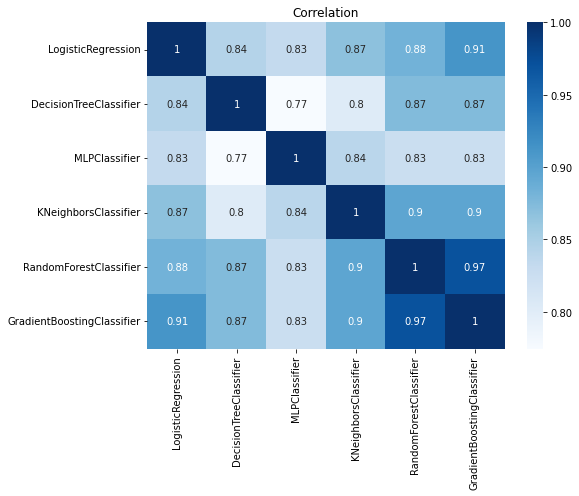

In [23]:
# 각 모델의 prediction 상관관계 확인
# 상관관계를 확인해야하는 이유?
# 높은 상관관계를 가지고 있다면, 같은(유사한) 값을 가졌다는 것 = Voting의 의미가 없음!

ensemble_results = pd.concat(pred_results, axis=1)
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(),annot=True, cmap='Blues')
g.set_title("Correlation")
plt.show()

In [8]:
from sklearn.ensemble import VotingClassifier

# 위에서 평가한 모든 모델을 앙상블할 경우
voting = VotingClassifier(estimators = [(type(clf).__name__, clf) for clf in clfs], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.958041958041958

In [9]:
# 가장 성능이 높은 GBM과 낮은 상관관계가 있는 모델끼리만 앙상블할 경우
voting = VotingClassifier(estimators = [('gbm', GBM), ('mlp', MLP), ('dt', DT)], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.958041958041958

In [10]:
# GBM과 성능이 비슷한 LR과 낮은 상관관계가 있는 모델끼리만 앙상블할 경우
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
voting.fit(X_train, y_train).score(X_test, y_test)

0.965034965034965

## Stacking

In [11]:
# vecstack 설치 필요
!pip install vecstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2-layer Stacking

In [25]:
from vecstack import stacking

models = clfs
S_train, S_test = stacking(models,                     # 모델 리스트
                           X_train, y_train, X_test,   # 데이터
                           regression=False,           # 분류 모델일 경우 False, 회귀 모델일 경우 True
                           needs_proba=False,          # 정답클래스로 예측할 경우 False, 확률로 예측할 경우 True
                           metric=accuracy_score,      # 평가지표
                           n_folds=5,                  # fold 개수 설정
                           random_state=34,
                           stratified=True,            # stratifiedKfold
                           shuffle = True,
                           verbose=2)                  # 결과 출력하기
meta_model = GBM.fit(S_train, y_train)
accuracy_score(y_test, meta_model.predict(S_test))

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [LogisticRegression]
    fold  0:  [0.91860465]
    fold  1:  [0.95294118]
    fold  2:  [0.96470588]
    fold  3:  [0.96470588]
    fold  4:  [0.92941176]
    ----
    MEAN:     [0.94607387] + [0.01883426]
    FULL:     [0.94600939]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.91860465]
    fold  1:  [0.90588235]
    fold  2:  [0.96470588]
    fold  3:  [0.90588235]
    fold  4:  [0.95294118]
    ----
    MEAN:     [0.92960328] + [0.02458937]
    FULL:     [0.92957746]

model  2:     [MLPClassifier]
    fold  0:  [0.91860465]
    fold  1:  [0.94117647]
    fold  2:  [0.96470588]
    fold  3:  [0.91764706]
    fold  4:  [0.90588235]
    ----
    MEAN:     [0.92960328] + [0.02094151]
    FULL:     [0.92957746]

model  3:     [KNeighborsClassifier]
    fold  0:  [0.90697674]
    fold  1:  [0.94117647]
    fold  2:  [0.94117647]
    fold

0.958041958041958

In [13]:
X_train.shape, S_train.shape, X_test.shape, S_test.shape

((426, 30), (426, 6), (143, 30), (143, 6))

### 3-layer Stacking

In [14]:
# level-1: LR, DT, MLP, KNN, RF, GBM

models = clfs
S_train, S_test = stacking(models,                     # 모델 리스트
                           X_train, y_train, X_test,   # 모델 리스트
                           regression=False,           # 분류 모델일 경우 False, 회귀 모델일 경우 True
                           needs_proba=True,           # 정답클래스로 예측할 경우 False, 확률로 예측할 경우 True
                           metric=accuracy_score,      # 평가지표
                           n_folds=3,                  # fold 개수 설정
                           random_state=34, 
                           stratified=True,            # stratifiedKfold 진행
                           shuffle=True,       
                           verbose=0)                  # 결과 출력하기

In [15]:
# level-2: LR, DT, KNN
# Level-3: Voting

voting = VotingClassifier(estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
voting.fit(S_train, y_train).score(S_test, y_test)

0.986013986013986

### `sklearn` 사용하기

In [16]:
from sklearn.ensemble import StackingClassifier

# 2-layer stacking

estimators = [(type(clf).__name__, clf) for clf in clfs]
stk_clf = StackingClassifier(
    estimators=estimators, final_estimator=GBM, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.965034965034965

In [17]:
# 3-layer stacking (Level-3: Voting)

layer_one_estimators = [(type(clf).__name__, clf) for clf in clfs]
voting = VotingClassifier(estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='hard')
stk_clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=voting, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.972027972027972

In [18]:
# 3-layer stacking (Level-3: LR)

layer_one_estimators = [(type(clf).__name__, clf) for clf in clfs]
layer_two_estimators = [('lr', LR), ('dt', DT), ('knn', KNN)]

layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LR)
stk_clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two, cv=5)

stk_clf.fit(X_train, y_train).score(X_test, y_test)

0.965034965034965

## Averaging
- 평가지표가 roc-auc, logloss 등일 경우 사용

<img align='left' src="https://t1.daumcdn.net/cfile/tistory/2454233C57FA242D11">

In [19]:
averaging = VotingClassifier(estimators = [('lr', LR), ('dt', DT), ('knn', KNN)], voting='soft')
averaging.fit(X_train, y_train)

print('AUC =', roc_auc_score(y_test, averaging.predict_proba(X_test)[:,1])) # 산술평균 (soft voting -> 확률평균 사용하는 보팅 방식)

AUC = 0.989098532494759


In [20]:
from scipy.stats.mstats import gmean

pred_logreg = LR.fit(X_train, y_train).predict_proba(X_test)[:,1]
pred_tree = DT.fit(X_train, y_train).predict_proba(X_test)[:,1]
pred_knn = KNN.fit(X_train, y_train).predict_proba(X_test)[:,1]

print('AUC = ', roc_auc_score(y_test, gmean([pred_logreg, pred_tree, pred_knn], axis=0))) # 기하평균

AUC =  0.9157232704402516
